# Section 1: Handling Data


Assuming you've downloaded the data, what exactly are we working with here? The data consists of many 2D "slices," which, when combined, produce a 3-dimensional rendering of whatever was scanned. In this case, that's the chest cavity of the patient. We've got CT scans of about 1500 patients, and then we've got another file that contains the labels for this data.
There are numerous ways that we could go about creating a classifier. Being a realistic data science problem, we actually don't really know what the best path is going to be. That's why this is a competition. Thus, we have to begin by simply trying things and seeing what happens!
I have a few theories about what might work, but my first interest was to try a 3D Convolutional Neural Network. I've never had data to try one on before, so I was excited to try my hand at it!
Before we can feed the data through any model, however, we need to at least understand the data we're working with. We know the scans are in this "dicom" format, but what is that? If you're like me, you have no idea what that is, or how it will look in Python! You can learn more about DICOM from Wikipedia if you like, but our main focus is what this will actually be in Python terms.
Luckily for us, there already exists a Python package for reading dicom files: Pydicom.
Do a pip install pydicom and pip install pandas and let's see what we've got!

In [10]:
%matplotlib inline
import dicom # for reading dicom files
import os # for doing directory operations 
import pandas as pd # for some simple data analysis (right now, just to load in the labels data and quickly reference it)

In [6]:
data_dir = '/local_work/kaggle/dataScienceBowl2017/data/sample_images/'
# Change this to wherever you are storing your data:
# IF YOU ARE FOLLOWING ON KAGGLE, YOU CAN ONLY PLAY WITH THE SAMPLE DATA, WHICH IS MUCH SMALLER
root_dir = '/local_work/kaggle/dataScienceBowl2017/data/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv(root_dir+'stage1_labels.csv', index_col=0)

labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


At this point, we've got the list of patients by their IDs, and their associated labels stored in a dataframe. Now, we can begin to iterate through the patients and gather their respective data. We're almost certainly going to need to do some preprocessing of this data, but we'll see.

In [7]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices),label)
    print(slices[0])

(134, 0)
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.247817952625791837963403492891187883824
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: '00cba091fa4ad62cc3200a657aeb957e'
(0010, 0020) Patient ID                          LO: '00cba091fa4ad62cc3200a657aeb957e'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.86208730140539712382771890501772734277950692397709007305473
(0020, 000e) Series Instance UID                 UI: 2.25.11575877329635228925808596800269974740893519451784626046614
(0020, 0011) Series Number                       IS: '3'
(0020, 0012) Acquisition Number   

Above, we iterate through each patient, we grab their label, we get the full path to that specific patient (inside THAT path contains ~200ish scans which we also iterate over, BUT also want to sort, since they wont necessarily be in proper order).


Do note here that the actual scan, when loaded by dicom, is clearly not JUST some sort of array of values, instead it's got attributes. There are a few attributes here of arrays, but not all of them. We're sorting by the actual image position in the scan. Later, we could actually put these together to get a full 3D rendering of the scan. That's not in my plans here, since that's already been something covered very well, see this kernel: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial


One immediate thing to note here is those rows and columns...holy moly, 512 x 512! This means, our 3D rendering is a 195 x 512 x 512 right now. That's huge!


Alright, so we already know that we're going to absolutely need to resize this data. Being 512 x 512, I am already expecting all this data to be the same size, but let's see what we have from other patients too:

In [8]:
for patient in patients[:3]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(slices[0].pixel_array.shape, len(slices))

((512, 512), 134)
((512, 512), 128)
((512, 512), 133)


Alright, so above we just went ahead and grabbed the pixel_array attribute, which is what I assume to be the scan slice itself (we will confirm this soon), but immediately I am surprised by this non-uniformity of slices. This isn't quite ideal and will cause a problem later. All of our images are the same size, but the slices arent. In terms of a 3D rendering, these actually are not the same size.


We've got to actually figure out a way to solve that uniformity problem, but also...these images are just WAY too big for a convolutional neural network to handle without some serious computing power. Thus, we already know out of the gate that we're going to need to downsample this data quite a bit, AND somehow make the depth uniform.


Welcome to datascience!


Okay, next question is...just how much data do we have here?

In [9]:
len(patients)

20

Oh.
(1595 in real data, 20 if you're in the Kaggle sample dataset)
Well, that's also going to be a challenge for the convnet to figure out, but we're going to try! Also, there are outside datasources for more lung scans. For example, you can grab data from the LUNA2016 challenge: https://luna16.grand-challenge.org/data/ for another 888 scans.
Do note that, if you do wish to compete, you can only use free datasets that are available to anyone who bothers to look.

I'll have us stick to just the base dataset, again mainly so anyone can poke around this code in the kernel environment.

Now, let's see what an actual slice looks like. If you do not have matplotlib, do pip install matplotlib


Want to learn more about Matplotlib? Check out the Data Visualization with Python and Matplotlib tutorial@ https://pythonprogramming.net/matplotlib-intro-tutorial/

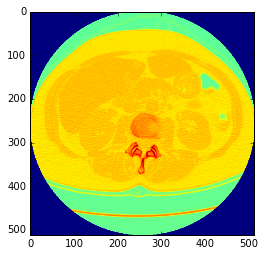

In [11]:
import matplotlib.pyplot as plt

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    #          the first slice
    plt.imshow(slices[0].pixel_array)
    plt.show()

Now, I am not a doctor, but I'm going to claim a mini-victory and say that's our first CT scan slice.
We have about 200 slices though, I'd feel more comfortable if I saw a few more. Let's look at the first 12, and resize them with opencv. If you do not have opencv, do a pip install cv2


Want to learn more about what you can do with Open CV? Check out the Image analysis and manipulation with OpenCV and Python tutorial.


You will also need numpy here. You probably already have numpy if you installed pandas, but, just in case, numpy is pip install numpy

# Section 2: Processing and viewing our Data

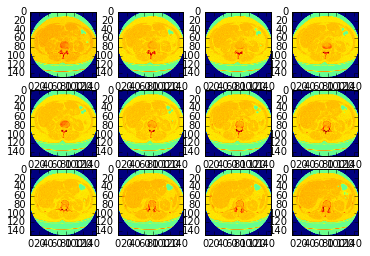

In [13]:
import cv2
import numpy as np

IMG_PX_SIZE = 150

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_img)
    plt.show()

Alright, so we're resizing our images from 512x512 to 150x150. 150 is still going to wind up likely being waaaaaaay to big. That's fine, we can play with that constant more later, we just want to know how to do it.


Okay, so now what? I think we need to address the whole non-uniformity of depth next. To be honest, I don't know of any super smooth way of doing this, but that's fine. I can at least think of A way, and that's all we need.


My thought is that, what we have is really a big list of slices. What we need is to be able to just take any list of images, whether it's got 200 scans, 150 scans, or 300 scans, and set it to be some fixed number. Let's say we want to have 20 scans instead. How can we do this? Well, first, we need something that will take our current list of scans, and chunk it into a list of lists of scans.


I couldn't think of anything off the top of my head for this, so I Googled "how to chunk a list into a list of lists." This is how real programming is happens.

As per Ned Batchelder via Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks, we've got ourselves a nice chunker generator. Awesome!Thanks Ned!


Okay, once we've got these chunks of these scans, what are we going to do? Well, we can just average them together. My theory is that a scan is a few millimeters of actual tissue at most. Thus, we can hopefully just average this slice together, and maybe we're now working with a centimeter or so. If there's a growth there, it should still show up on scan.
This is just a theory, it has to be tested.


As we continue through this, however, you're hopefully going to see just how many theories we come up with, and how many variables we can tweak and change to possibly get better results.

In [28]:
import math

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l) / len(l)

IMG_PX_SIZE = 150
HM_SLICES = 20

data_dir = '/local_work/kaggle/dataScienceBowl2017/data/sample_images/'
patients = os.listdir(data_dir)
root_dir = '/local_work/kaggle/dataScienceBowl2017/data/'
labels_df = pd.read_csv(root_dir+'stage1_labels.csv', index_col=0)

for patient in patients[:10]:
    
    #print patient
    
    try:
        label = labels_df.get_value(patient, 'cancer')    
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []
        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        
        chunk_sizes = int(math.ceil(len(slices) / HM_SLICES))
        
        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        print(len(slices), len(new_slices))
    except:
        # some patients don't have labels, so we'll just pass on this for now
        pass


(134, 23)
(128, 22)
(133, 23)
(110, 22)
(203, 21)
(280, 20)
(123, 21)
(164, 21)
(244, 21)


The struggle is real. Okay, what you're about to see you shouldn't attempt if anyone else is watching, like if you're going to show your code to the public...

In [30]:
for patient in patients[:10]:
    try:
        label = labels_df.get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]

        chunk_sizes = int(math.ceil(len(slices) / HM_SLICES))


        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        print(len(slices), len(new_slices))
    except Exception as e:
        # again, some patients are not labeled, but JIC we still want the error if something
        # else is wrong with our code
        print(str(e))

(134, 23)
(128, 20)
(133, 23)
(110, 20)
(203, 20)
'0b20184e0cd497028bdd155d9fb42dc9'
(280, 20)
(123, 20)
(164, 20)
(244, 20)


Okay, the Python gods are really not happy with me for that hacky solution. If any of you would like to improve this chunking/averaging code, feel free. Really, any of this code...if you have improvements, share them! This is going to stay pretty messy. But hey, we did it! We figured out a way to make sure our 3 dimensional data can be at any resolution we want or need. Awesome!


That's actually a decently large hurdle. Are we totally done? ...maybe not. One major issue is these colors and ranges of data. It's unclear to me whether or not a model would appreciate that. Even if we do a grayscale colormap in the imshow, you'll see that some scans are just darker overall than others. This might be problematic and we might need to actually normalize this dataset.


I expect that, with a large enough dataset, this wouldn't be an actual issue, but, with this size of data, it might be of huge importance.


In effort to not turn this notebook into an actual book, however, we're going to move forward! We can now see our new data by doing:

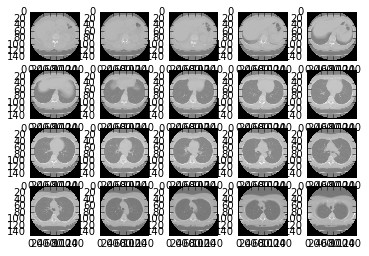

In [36]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    new_slices = []

    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = int(math.ceil(len(slices) / HM_SLICES))
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    
    fig = plt.figure()
    for num,each_slice in enumerate(new_slices):
        if num < 20:
           y = fig.add_subplot(4,5,num+1)
           y.imshow(each_slice, cmap='gray')
    plt.show()
